# Decoding Sleep stages from the aperiodic parameters of iEEG data  

In [14]:
import os
from pathlib import Path
import numpy as np
import mne
from scipy import stats
import pandas as pd
import random
import Pickle

# Plotting functions
from spiketools.plts.utils import make_axes
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table 

import warnings
warnings.filterwarnings("ignore")

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

import sys
sys.path.append("/home/b1044271/Columbia/Aperiodic_sleep/helpers")
from utils import check_distribution, perform_correlation, compute_z_values, bonferroni_correction, friedman_dunns

# Import custom made code
import sys
sys.path.append("/home/b1044271/Columbia/Aperiodic_sleep/helpers")
from utils import check_distribution, perform_correlation, compute_z_values, bonferroni_correction, friedman_dunns

## Load iEEG data

In [ ]:
save_path = '/home/b1044271/Columbia/Results/2025/iEEG_results.pkl'

with open(save_path, 'rb') as f:
    loaded_data = pickle.load(f)
    PSDs_W = loaded_data['PSDs']['Wakefulness']
    PSDs_N2 = loaded_data['PSDs']['N2']
    PSDs_N3 = loaded_data['PSDs']['N3']
    PSDs_R = loaded_data['PSDs']['REM']
    param_data = loaded_data['param_data']

## Extract parameters

In [ ]:
# Exponent Knee
W_Exp = param_data["Wakefulness"]["Exp"]
N2_Exp = param_data["N2"]["Exp"]
N3_Exp = param_data["N3"]["Exp"]
R_Exp = param_data["REM"]["Exp"]

# KNee Frequency
W_Kn = param_data["Wakefulness"]["Kn"]
N2_Kn = param_data["N2"]["Kn"]
N3_Kn = param_data["N3"]["Kn"]
R_Kn = param_data["REM"]["Kn"]

# Exponent Fixed
W_Exp2 = param_data["Wakefulness"]["Exp2"]
N2_Exp2 = param_data["N2"]["Exp2"]
N3_Exp2 = param_data["N3"]["Exp2"]
R_Exp2 = param_data["REM"]["Exp2"]


## Run LDA Classification 

In [98]:
# repititions 
lin_method = RepeatedStratifiedKFold (n_splits = 5, n_repeats = 2, random_state = 1)

# Set up the repeated k-fold cross-validation
lin_method = RepeatedKFold(n_splits=5, n_repeats=2)

# reset seed
random.seed(0)
np.random.seed(0)

trials=np.zeros(38)*np.nan

accuracy_K=[]
accuracy_F=[]
accuracy_knee=[]


for i in np.arange(38):

    # Initialize the LDA classifier
    lda = LinearDiscriminantAnalysis()
 ##################################################   
    # DATA
    W_exp   = W_Exp[i][~np.isnan(W_Exp[i])]
    W_knee  = Kn_W[i][~np.isnan(Kn_W[i])]
    mask = np.isfinite(W_knee)
    W_knee = W_knee[mask]
    W_exp2  = W_Exp2[i][~np.isnan(W_Exp2[i])]

    N2_exp   = N2_Exp[i][~np.isnan(N2_Exp[i])]
    N2_knee  = Kn_N2[i][~np.isnan(Kn_N2[i])]
    N2_exp2  = N2_Exp2[i][~np.isnan(N2_Exp2[i])]

    N3_exp   = N3_Exp[i][~np.isnan(N3_Exp[i])]
    N3_knee  = Kn_N3[i][~np.isnan(Kn_N3[i])]
    N3_exp2  = N3_Exp2[i][~np.isnan(N3_Exp2[i])]

    R_exp   = R_Exp[i][~np.isnan(R_Exp[i])]
    R_knee  = Kn_R[i][~np.isnan(Kn_R[i])]
    R_exp2  = R_Exp2[i][~np.isnan(R_Exp2[i])]

    ###################################################
         # equate number of trials per stage
    L  = min([len(W_exp) ,  len(N2_exp), len(N3_exp),  len(R_exp),
               len(W_knee) , len(N2_knee), len(N3_knee),  len(R_knee),
               len(W_exp2) , len(N2_exp2), len(N3_exp2),  len(R_exp2)])
    
    trials[i] = L
    
    W_exp  = W_exp[random.sample(range(0, len(W_exp)), L)] 
    l1  = np.ones(len(W_exp))
 
    N2_exp = N2_exp[random.sample(range(0, len(N2_exp)), L)]
    l2  = np.ones(len(N2_exp))*2

    N3_exp = N3_exp[random.sample(range(0, len(N3_exp)), L)]
    l3  = np.ones(len(N3_exp))*3
    
    R_exp  = R_exp[random.sample(range(0, len(R_exp)), L)]
    l4  = np.ones(len(R_exp))*4
    
    #########################################
    W_exp2  = W_exp2[random.sample(range(0, len(W_exp2)), L)] 
    N2_exp2 = N2_exp2[random.sample(range(0, len(N2_exp2)), L)]
    N3_exp2 = N3_exp2[random.sample(range(0, len(N3_exp2)), L)]
    R_exp2  = R_exp2[random.sample(range(0, len(R_exp2)), L)]

    ############################################    
    W_knee  = W_knee[random.sample(range(0, len(W_knee)), L)] 
    N2_knee = N2_knee[random.sample(range(0, len(N2_knee)), L)]  
    N3_knee = N3_knee[random.sample(range(0, len(N3_knee)), L)]
    R_knee  = R_knee[random.sample(range(0, len(R_knee)), L)]

    
    Knee_model  = np.concatenate((W_exp,N2_exp,N3_exp,R_exp))
    Fixed_model  = np.concatenate((W_exp2,N2_exp2,N3_exp2,R_exp2))
    Knee_value  = np.concatenate((W_knee,N2_knee,N3_knee,R_knee))

    y = np.concatenate((l1,l2,l3,l4))
    ###########################################
    
    # make the 1d array a 2d array (req for scikit learn)
    X=Knee_model[:, None]
    X2=Fixed_model[:, None]
    X3=Knee_value[:, None]

    ################################################
    # Loop over the cross-validation folds and repetitions
    lin_score = cross_val_score(lda, X, y, scoring = 'accuracy', cv = lin_method, n_jobs = -1)
    # Split the data into training and test sets
    X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2)
    # Fit the LDA model on the training data
    lda.fit(X_train, y_train)
    # Evaluate the model on the test data
    accuracy_K.append(lda.score(X_test, y_test))
    

    # Initialize the LDA classifier
    lda2 = LinearDiscriminantAnalysis()
    # Loop over the cross-validation folds and repetitions
    lin_score2 = cross_val_score(lda2, X2, y, scoring = 'accuracy', cv = lin_method, n_jobs = -1)
    # Split the data into training and test sets
    X_train2, X_test2 , y_train2, y_test2 = train_test_split(X2, y, test_size=0.2)
    # Fit the LDA model on the training data
    lda2.fit(X_train2, y_train2)
    # Evaluate the model on the test data
    accuracy_F.append(lda2.score(X_test2, y_test2))
    
    # Initialize the LDA classifier
    lda3 = LinearDiscriminantAnalysis()
    # Loop over the cross-validation folds and repetitions
    lin_score3 = cross_val_score(lda3, X3, y, scoring = 'accuracy', cv = lin_method, n_jobs = -1)
    # Split the data into training and test sets
    X_train3, X_test3 , y_train3, y_test3 = train_test_split(X3, y, test_size=0.2)
    # Fit the LDA model on the training data
    lda3.fit(X_train3, y_train3)
    # Evaluate the model on the test data
    accuracy_knee.append(lda3.score(X_test3, y_test3))

trials

array([ 21., 220., 135., 228.,  51., 208., 128., 108., 224., 160.,  39.,
       107., 208.,  93.,  61.,  70.,  82., 144., 721., 474., 130.,  91.,
        71.,  89., 216.,  94.,  96., 410., 184.,  86., 427., 205., 325.,
       176., 270.,  49.,  21., 187.])

## PLotting

In [ ]:
array_list6 = [accuracy_knee,accuracy_K, accuracy_F]
colors = ['black', 'grey', 'silver']

import seaborn
titles =  ['knee freq','exponent - knee','exponent - fixed']


ax = plt.figure(figsize=(3,3))  

ax = seaborn.swarmplot(data=array_list6, palette = colors);
ax.set_xticklabels(titles)

seaborn.scatterplot(x=[0,1,2], y=np.mean(array_list6,1), marker='X', color='black', s=100, zorder=4, legend=False);
ax.axhline(y=0.25, color='black', linestyle='--');

plt.title('Stages decoding', fontsize = 24)
plt.ylabel('accuracy (a.u.)',fontsize=20)

plt.ylim(-0.05, 0.7)
plt.xlim(-0.5, 2.5)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)


plt.savefig("/home/b1044271/Columbia/Plots/NOV24/iEEG_decoding.svg", dpi = 600)

# STATS

## Permutation statistics versus chance

In [99]:
# FIRST PERMUTATION
ACC = [accuracy_knee,accuracy_K, accuracy_F]

# Specify the number of permutations
num_permutations = 10000

tvalue=np.zeros(3)
pvalue=np.zeros(3)
cohend=np.zeros(3)
for i in np.arange(len(ACC)):
    X = ACC[i]
    # Perform the permutation test
    tvalue[i],pvalue[i],cohend[i] = perform_permutation_test(X, np.ones(34)*0.25, num_permutations)

pvalue_bonf = pvalue * len(ACC)


# Create a DataFrame to store the results
results_table = pd.DataFrame({
    "Metric": ["Accuracy Knee", "Accuracy K", "Accuracy F"],
    "T-Value": tvalue,
    "P-Value (Bonferroni)": pvalue_bonf,
    "Cohen's D": cohend
})

# Save the table to a CSV file
file_path = "permutation_test_results.csv"
results_table.to_csv('/home/b1044271/Columbia/Plots/NOV24/Decode_iEEG_stats_chance.svg', index=False)


pvalue_bonf, tvalue, cohend

(array([0.    , 2.8002, 0.    ]),
 array([ 5.90935112, -1.48861907, 10.10241511]),
 array([ 1.43430538, -0.36131452,  2.45203712]))

## Friedmann between parameters

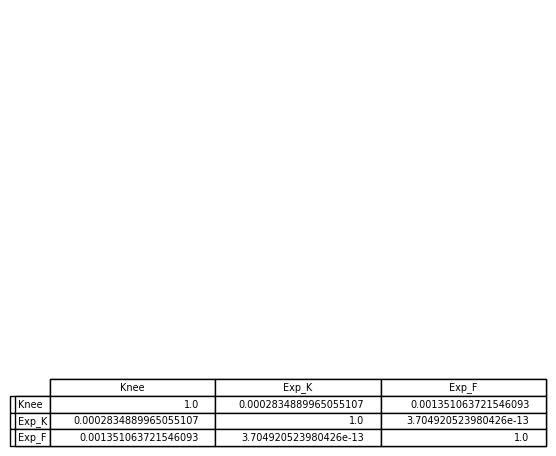

In [86]:
# Decoding stats repeated measures
data = pd.DataFrame(np.transpose(ACC))

friedman_result, W, posthoc_result, z_values, effect_sizes, corrected_p_values = friedman_dunns(data)

# Change the column names
effect_sizes.columns =['Knee', 'Exp_K', 'Exp_F']
corrected_p_values.columns = ['Knee', 'Exp_K', 'Exp_F']
# Change the row indexes
effect_sizes.index = ['Knee', 'Exp_K', 'Exp_F']
corrected_p_values.index = ['Knee', 'Exp_K', 'Exp_F']

ax = plt.subplot(111, frame_on=False) # no visible frame
table(ax, effect_sizes)  # where df is your data frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
plt.savefig('/home/b1044271/Columbia/Plots/NOV24/Decode_iEEG_effectS.svg')

ax = plt.subplot(111, frame_on=False) # no visible frame
table(ax, corrected_p_values)  # where df is your data frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
plt.savefig('/home/b1044271/Columbia/Plots/NOV24/Decode_iEEG_Pvalues.svg')

## Using Knee and Exponent to Predict stages

### We will use a random forest classifier to gain info on which feature is better

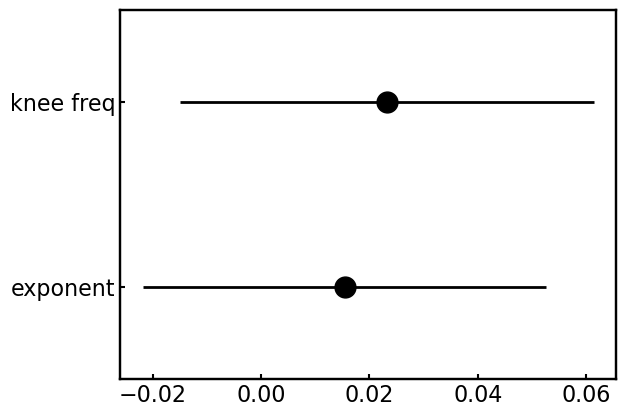

In [94]:
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Reset seed for replicability
random.seed(0)
np.random.seed(0)

# Add empty lists for results
accuracy_KE = []
perm_importance_results = []

# Loop over subjects
for i in np.arange(34):
    ##################################################
    # DATA
    W_exp = W_Exp[i][~np.isnan(W_Exp[i])]
    W_knee = Kn_W[i][~np.isnan(Kn_W[i])]

    N2_exp = N2_Exp[i][~np.isnan(N2_Exp[i])]
    N2_knee = Kn_N2[i][~np.isnan(Kn_N2[i])]

    N3_exp = N3_Exp[i][~np.isnan(N3_Exp[i])]
    N3_knee = Kn_N3[i][~np.isnan(Kn_N3[i])]

    R_exp = R_Exp[i][~np.isnan(R_Exp[i])]
    R_knee = Kn_R[i][~np.isnan(Kn_R[i])]

    ###################################################
    # Equate the number of trials per stage
    L = min([len(W_exp), len(N2_exp), len(N3_exp), len(R_exp),
             len(W_knee), len(N2_knee), len(N3_knee), len(R_knee)])
    
    # Sample equal number of trials for each stage
    W_exp = np.random.choice(W_exp, L, replace=False)
    N2_exp = np.random.choice(N2_exp, L, replace=False)
    N3_exp = np.random.choice(N3_exp, L, replace=False)
    R_exp = np.random.choice(R_exp, L, replace=False)

    W_knee = np.random.choice(W_knee, L, replace=False)
    N2_knee = np.random.choice(N2_knee, L, replace=False)
    N3_knee = np.random.choice(N3_knee, L, replace=False)
    R_knee = np.random.choice(R_knee, L, replace=False)

    # Labels for sleep stages
    y = np.concatenate([np.ones(L), np.ones(L) * 2, np.ones(L) * 3, np.ones(L) * 4])

    ###################################################
    # Combine features for knee and exponent
    X = np.column_stack([
        np.concatenate([W_exp, N2_exp, N3_exp, R_exp]),
        np.concatenate([W_knee, N2_knee, N3_knee, R_knee])
    ])

    ###################################################
    # Random Forest Classification
    classifier = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train-test split for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the model and compute accuracy
    classifier.fit(X_train, y_train)
    accuracy_KE.append(classifier.score(X_test, y_test))

    ###################################################
    # Permutation Importance
    perm_importance = permutation_importance(
        classifier, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy'
    )
    perm_importance_results.append(perm_importance.importances_mean)

###################################################
# Aggregate Results
mean_accuracy = np.mean(accuracy_KE)
std_accuracy = np.std(accuracy_KE)
mean_perm_importance = np.mean(perm_importance_results, axis=0)
sem_perm_importance = np.std(perm_importance_results, axis=0)/ np.sqrt(len(mean_perm_importance))

###################################################
# Plot Permutation Importance
titles =  ['exponent','knee freq']
fig, axs = plt.subplots()
axs.set_ylim([-0.5,1.5])

axs.errorbar(mean_perm_importance, [0,1], xerr=sem_perm_importance, fmt="o", markersize= 15, 
             elinewidth=2, color = 'k')
axs.yaxis.set_ticks(np.arange(2))
axs.set_yticklabels(titles)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

axs.spines['top'].set_linewidth(1.75)
axs.spines['right'].set_linewidth(1.75)
axs.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
axs.spines['bottom'].set_linewidth(1.75)
axs.spines['left'].set_linewidth(1.75)

plt.savefig("/home/b1044271/Columbia/Plots/NOV24/iEEG_decoding_feat_imp.svg", dpi = 600)


### Stats

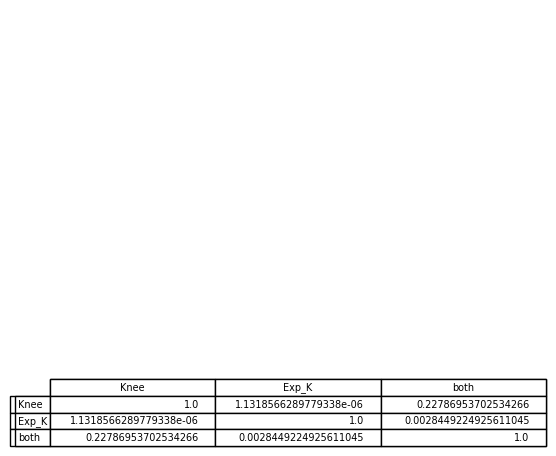

In [74]:
from utils import calculate_t_statistic, calculate_cohens_d, perform_permutation_test

ACC = [accuracy_knee,accuracy_K, accuracy_KE]

# FRIEDMAN
# Decoding stats repeated measures
data = pd.DataFrame(np.transpose(ACC))

friedman_result, W, posthoc_result, z_values, effect_sizes, corrected_p_values = friedman_dunns(data)

# Change the column names
effect_sizes.columns =['Knee', 'Exp_K', 'both']
corrected_p_values.columns = ['Knee', 'Exp_K', 'both']
# Change the row indexes
effect_sizes.index = ['Knee', 'Exp_K', 'both']
corrected_p_values.index = ['Knee', 'Exp_K', 'both']

ax = plt.subplot(111, frame_on=False) # no visible frame
table(ax, effect_sizes)  # where df is your data frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
plt.savefig('/home/b1044271/Columbia/Plots/NOV24/Decode_iEEG_effectS.svg')

ax = plt.subplot(111, frame_on=False) # no visible frame
table(ax, corrected_p_values)  # where df is your data frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
plt.savefig('/home/b1044271/Columbia/Plots/NOV24/Decode_iEEG_Pvalues.svg')

# PLOT accuracy of KNEE, EXP, AND BOTH

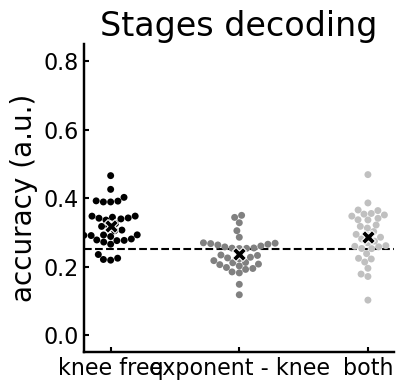

In [72]:
array_list6 = [accuracy_knee,accuracy_K, accuracy_KE]
colors = ['black', 'grey', 'silver']

import seaborn
titles =  ['knee freq','exponent - knee','both']


ax = plt.figure(figsize=(4,4))  

ax = seaborn.swarmplot(data=array_list6, palette = colors);
ax.set_xticklabels(titles)

seaborn.scatterplot(x=[0,1,2], y=np.mean(array_list6,1), marker='X', color='black', s=100, zorder=4, legend=False);
#plt.plot([array_list6[0], array_list6[1], array_list6[2]], color = 'grey', linewidth = 0.25, linestyle = '-');
ax.axhline(y=0.25, color='black', linestyle='--');

plt.title('Stages decoding', fontsize = 24)
plt.ylabel('accuracy (a.u.)',fontsize=20)

plt.ylim(-0.05, 0.85)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
ax.spines['bottom'].set_linewidth(1.75)
ax.spines['left'].set_linewidth(1.75)


plt.savefig("/home/b1044271/Columbia/Plots/NOV24/iEEG_decoding_both.svg", dpi = 600)

# Random Forest

In [10]:
# import random forest 
from sklearn.ensemble import RandomForestClassifier

# Set up the repeated k-fold cross-validation
lin_method = RepeatedKFold(n_splits=5, n_repeats=2)

# reset seed for replicability
random.seed(0)
np.random.seed(0)

# add empty vectors for results
trials=np.zeros(34)*np.nan

accuracy_KE=[]


# start loop
for i in np.arange(38):
    

 ##################################################   
    # DATA
    W_exp   = W_Exp[i][~np.isnan(W_Exp[i])]
    W_knee  = Kn_W[i][~np.isnan(Kn_W[i])]
    mask = np.isfinite(W_knee)
    W_knee = W_knee[mask]

    N2_exp   = N2_Exp[i][~np.isnan(N2_Exp[i])]
    N2_knee  = Kn_N2[i][~np.isnan(Kn_N2[i])]

    N3_exp   = N3_Exp[i][~np.isnan(N3_Exp[i])]
    N3_knee  = Kn_N3[i][~np.isnan(Kn_N3[i])]

    R_exp   = R_Exp[i][~np.isnan(R_Exp[i])]
    R_knee  = Kn_R[i][~np.isnan(Kn_R[i])]

    ###################################################
    # equate number of trials per stage
    
    L  = min([len(W_exp) ,  len(N2_exp),  len(N3_exp),  len(R_exp),
              len(W_knee) , len(N2_knee), len(N3_knee), len(R_knee)])
    
    trials[i] = L
    
    W_exp  = W_exp[random.sample(range(0, len(W_exp)), L)] 
    l1  = np.ones(len(W_exp))
 
    N2_exp = N2_exp[random.sample(range(0, len(N2_exp)), L)]
    l2  = np.ones(len(N2_exp))*2

    N3_exp = N3_exp[random.sample(range(0, len(N3_exp)), L)]
    l3  = np.ones(len(N3_exp))*3
    
    R_exp  = R_exp[random.sample(range(0, len(R_exp)), L)]
    l4  = np.ones(len(R_exp))*4
    
    ############################################    
    W_knee  = W_knee[random.sample(range(0, len(W_knee)), L)] 
    N2_knee = N2_knee[random.sample(range(0, len(N2_knee)), L)]  
    N3_knee = N3_knee[random.sample(range(0, len(N3_knee)), L)]
    R_knee  = R_knee[random.sample(range(0, len(R_knee)), L)]

    
    Knee_model  = np.concatenate((W_exp,N2_exp,N3_exp,R_exp))
    Knee_value  = np.concatenate((W_knee,N2_knee,N3_knee,R_knee))

    y = np.concatenate((l1,l2,l3,l4))
    ###########################################
    
    # make the 1d array a 2d array (req for scikit learn)
    X=[Knee_model, Knee_value]

    ################################################
    classifier = RandomForestClassifier(n_estimators=100, random_state=42)

    lin_score = cross_val_score(classifier, np.transpose(X), y, scoring = 'accuracy', cv = lin_method, n_jobs = -1)
    
    # Split the data into training and test sets
    X_train, X_test , y_train, y_test = train_test_split(np.transpose(X), y, test_size=0.2)
    
    # Fit the LDA model on the training data
    classifier.fit(X_train, y_train)
    # Evaluate the model on the test data
    accuracy_KE.append(classifier.score(X_test, y_test))
    
trials

ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.

In [1]:
from sklearn.inspection import permutation_importance
import time
feature_names = ['Exp','Knee']
start_time = time.time()
result = permutation_importance(classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

NameError: name 'classifier' is not defined